# **Forecast da Temperatura com o ERA5**

#### Localidade: Mogi Guaçu/SP

#### Autor: Thiago Wendling Gonçalves de Oliveira

### Bibliotecas


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import xarray as xr
import glob
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

### Carregando os dados diários
- temperatura
- radiação
- pressão
- orvalho
- cobertura de nuvens

##### Temperatura

In [2]:
url = 'https://raw.githubusercontent.com/ThiagoWGdeOliveira/forecast-temperatura-era5/main/data/temperatura.xlsx'

Saving temp_diarias_1959_2024.xlsx to temp_diarias_1959_2024.xlsx


In [3]:
df_temperatura = pd.read_excel(url)
df_temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   24107 non-null  int64         
 1   data         24107 non-null  datetime64[ns]
 2   temp_maxima  24107 non-null  float64       
 3   temp_media   24107 non-null  float64       
 4   temp_minima  24107 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 941.8 KB


In [4]:
df_temperatura = df_temperatura.drop(columns=['Unnamed: 0'])
df_temperatura = df_temperatura[df_temperatura['data']>='1980-01-01'].reset_index(drop=True)
df_temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         16437 non-null  datetime64[ns]
 1   temp_maxima  16437 non-null  float64       
 2   temp_media   16437 non-null  float64       
 3   temp_minima  16437 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 513.8 KB


In [ ]:
df_temperatura

##### Orvalho

In [7]:
url = 'https://raw.githubusercontent.com/ThiagoWGdeOliveira/forecast-temperatura-era5/main/data/temperatura_orvalho.xlsx'

Saving temp_orvalho_diaria.xlsx to temp_orvalho_diaria.xlsx


In [8]:
df_orvalho = pd.read_excel(url)
df_orvalho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       16437 non-null  int64         
 1   data             16437 non-null  datetime64[ns]
 2   orvalho_celsius  16437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 385.4 KB


In [ ]:
df_orvalho = df_orvalho.drop(columns=['Unnamed: 0'])
df_orvalho

##### Pressão

In [11]:
url = 'https://raw.githubusercontent.com/ThiagoWGdeOliveira/forecast-temperatura-era5/main/data/pressao_nivel_do_mar.xlsx'

Saving pressao_nivel_mar_diaria.xlsx to pressao_nivel_mar_diaria.xlsx


In [12]:
df_pressao = pd.read_excel(url)
df_pressao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   16437 non-null  int64         
 1   data         16437 non-null  datetime64[ns]
 2   pressao_hPa  16437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 385.4 KB


In [ ]:
df_pressao = df_pressao.drop(columns=['Unnamed: 0'])
df_pressao

##### Radiação Solar

In [15]:
url = 'https://raw.githubusercontent.com/ThiagoWGdeOliveira/forecast-temperatura-era5/main/data/radiacao.xlsx'

Saving radiacao_diaria.xlsx to radiacao_diaria.xlsx


In [16]:
df_radiacao = pd.read_excel(url)
df_radiacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  16437 non-null  int64         
 1   data        16437 non-null  datetime64[ns]
 2   ssdr_MJ_m2  16437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 385.4 KB


In [ ]:
df_radiacao = df_radiacao.drop(columns=['Unnamed: 0'])
df_radiacao

##### Cobertura de Nuvens

In [19]:
url = 'https://raw.githubusercontent.com/ThiagoWGdeOliveira/forecast-temperatura-era5/main/data/cobertura_nuvens.xlsx'

Saving cloud_cover_diaria.xlsx to cloud_cover_diaria.xlsx


In [20]:
df_nuvens = pd.read_excel(url)
df_nuvens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  16437 non-null  int64         
 1   data        16437 non-null  datetime64[ns]
 2   cloud       16437 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 385.4 KB


In [21]:
df_nuvens = df_nuvens.drop(columns=['Unnamed: 0'])
df_nuvens

,data,cloud
0,1980-01-01,0.934537
1,1980-01-02,0.347232
2,1980-01-03,0.160269
3,1980-01-04,0.194462
4,1980-01-05,0.183450
...,...,...
16432,2024-12-27,0.986806
16433,2024-12-28,0.665933
16434,2024-12-29,0.470239
16435,2024-12-30,0.271859


##### Juntando os dataframes

In [23]:
df_juntos = pd.merge(df_temperatura, df_orvalho, on='data', how='inner')
df_juntos = pd.merge(df_juntos, df_pressao, on='data', how='inner')
df_juntos = pd.merge(df_juntos, df_radiacao, on='data', how='inner')
df_juntos = pd.merge(df_juntos, df_nuvens, on='data', how='inner')
df_juntos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             16437 non-null  datetime64[ns]
 1   temp_maxima      16437 non-null  float64       
 2   temp_media       16437 non-null  float64       
 3   temp_minima      16437 non-null  float64       
 4   orvalho_celsius  16437 non-null  float64       
 5   pressao_hPa      16437 non-null  float64       
 6   ssdr_MJ_m2       16437 non-null  float64       
 7   cloud            16437 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.0 MB


### Limpeza, Organização e Visualização dos Dados

In [24]:
df_juntos.describe()

,data,temp_maxima,temp_media,temp_minima,orvalho_celsius,pressao_hPa,ssdr_MJ_m2,cloud
count,16437,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,2002-07-02 00:00:00,27.508353,21.729912,16.893243,15.813690,1015.262330,18.434699,0.530669
min,1980-01-01 00:00:00,11.638336,7.978963,1.169586,-2.699015,1003.406006,1.455006,0.000000
25%,1991-04-02 00:00:00,25.384186,19.664236,14.471344,13.082316,1012.568054,14.998544,0.231758
50%,2002-07-02 00:00:00,27.708405,22.175943,17.671295,16.435984,1014.845032,18.436972,0.544642
75%,2013-10-01 00:00:00,29.925690,23.977386,19.795074,19.040579,1017.770325,22.779963,0.847229
max,2024-12-31 00:00:00,39.135406,31.703583,25.075348,22.870056,1029.777466,32.895775,1.000000
std,NaN,3.434220,3.071610,3.556610,3.742736,3.760224,5.606083,0.328387


In [25]:
df_juntos.isna().sum()

,0
data,0
temp_maxima,0
temp_media,0
temp_minima,0
orvalho_celsius,0
pressao_hPa,0
ssdr_MJ_m2,0
cloud,0


In [26]:
# Cálculo da Umidade Relativa:
df_juntos['umidade_rel'] = 100 * (np.exp((17.625 * df_juntos['orvalho_celsius'])/(243.04 + df_juntos['orvalho_celsius'])) / np.exp((17.625 * df_juntos['temp_media'])/(243.04 + df_juntos['temp_media'])))
df_juntos.head()

,data,temp_maxima,temp_media,temp_minima,orvalho_celsius,pressao_hPa,ssdr_MJ_m2,cloud,umidade_rel
0,1980-01-01,24.277740,21.259481,18.407867,18.701111,1008.490234,11.116764,0.934537,85.349371
1,1980-01-02,26.679108,21.514252,16.417145,14.391429,1011.143982,29.497034,0.347232,63.890159
2,1980-01-03,27.709625,21.260477,15.301666,13.623424,1012.860840,28.436806,0.160269,61.739369
3,1980-01-04,28.904205,22.445587,15.401276,14.659739,1013.688660,27.001343,0.194462,61.417143
4,1980-01-05,29.667877,23.861023,17.666412,15.324636,1015.269836,26.483057,0.183450,58.844561


In [27]:
# Retirando columas que não seram usadas:
df_juntos = df_juntos.drop(columns=['temp_maxima', 'temp_minima', 'orvalho_celsius'])
df_juntos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         16437 non-null  datetime64[ns]
 1   temp_media   16437 non-null  float64       
 2   pressao_hPa  16437 non-null  float64       
 3   ssdr_MJ_m2   16437 non-null  float64       
 4   cloud        16437 non-null  float64       
 5   umidade_rel  16437 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 770.6 KB


In [ ]:
variaveis = ['temp_media', 'pressao_hPa', 'ssdr_MJ_m2', 'cloud', 'umidade_rel']

fig, axes = plt.subplots(ncols=len(variaveis), figsize=(20,8))

for ax, var in zip(axes, variaveis):
  sns.histplot(data=df_juntos, x=var, ax=ax, bins=30)
  ax.set_xlabel(f'{var}')
  ax.set_ylabel('')
plt.tight_layout()
plt.savefig('output/Histograma_variaveis_diarias.png', dpi=400)
plt.show()


##### Transformação em valores mensais:


In [29]:
df_juntos['data'] = pd.to_datetime(df_juntos['data'])
df_juntos['mes'] = df_juntos['data'].dt.to_period('M')
df_mensal = df_juntos.groupby('mes').agg({
    'temp_media':'mean',
    'pressao_hPa':'mean',
    'ssdr_MJ_m2':'sum',
    'cloud':'mean',
    'umidade_rel':'mean'
}).reset_index()
df_mensal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   mes          540 non-null    period[M]
 1   temp_media   540 non-null    float64  
 2   pressao_hPa  540 non-null    float64  
 3   ssdr_MJ_m2   540 non-null    float64  
 4   cloud        540 non-null    float64  
 5   umidade_rel  540 non-null    float64  
dtypes: float64(5), period[M](1)
memory usage: 25.4 KB


In [ ]:
sns.pairplot(df_mensal)
plt.savefig('output/Relacao_entre_variaveis.png', dpi=400)
plt.show()

In [32]:
df_mensal.head(5)

,mes,temp_media,pressao_hPa,ssdr_MJ_m2,cloud,umidade_rel
0,1980-01,22.929112,1012.599275,624.334470,0.750213,75.832103
1,1980-02,23.399217,1011.744233,563.523062,0.746571,76.475960
2,1980-03,24.272253,1014.558090,631.052459,0.479400,72.654768
3,1980-04,21.742498,1015.636666,502.861004,0.507998,77.216530
4,1980-05,19.639042,1017.689032,455.085759,0.431836,73.868129


##### Transformação das variávies

In [33]:
df_mensal['pressao_log'] = np.log(df_mensal['pressao_hPa'])
df_mensal['ssdr_log'] = np.log(df_mensal['ssdr_MJ_m2'])
df_mensal['umidade_relativa'] = df_mensal['umidade_rel']/100
df_mensal_modelo = df_mensal.drop(columns=['pressao_hPa', 'ssdr_MJ_m2', 'umidade_rel'])
df_mensal_modelo.head(10)

,mes,temp_media,cloud,pressao_log,ssdr_log,umidade_relativa
0,1980-01,22.929112,0.750213,6.920276,6.436686,0.758321
1,1980-02,23.399217,0.746571,6.919431,6.334208,0.764760
2,1980-03,24.272253,0.479400,6.922208,6.447389,0.726548
3,1980-04,21.742498,0.507998,6.923271,6.220314,0.772165
4,1980-05,19.639042,0.431836,6.925290,6.120486,0.738681
5,1980-06,16.989324,0.412178,6.926927,5.979051,0.720864
6,1980-07,18.843903,0.533259,6.926162,6.061293,0.677414
7,1980-08,20.004460,0.472114,6.925717,6.158455,0.658623
8,1980-09,19.391816,0.617187,6.923988,6.289713,0.674728
9,1980-10,22.624445,0.608343,6.922877,6.495088,0.643335


### Modelos

##### Ajustes

In [34]:
df_mensal_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   mes               540 non-null    period[M]
 1   temp_media        540 non-null    float64  
 2   cloud             540 non-null    float64  
 3   pressao_log       540 non-null    float64  
 4   ssdr_log          540 non-null    float64  
 5   umidade_relativa  540 non-null    float64  
dtypes: float64(5), period[M](1)
memory usage: 25.4 KB


In [35]:
# Criação de uma variável tempo como número crescente:
df_mensal_modelo['tempo'] = np.arange(len(df_mensal_modelo))
df_mensal_modelo.head(3)

,mes,temp_media,cloud,pressao_log,ssdr_log,umidade_relativa,tempo
0,1980-01,22.929112,0.750213,6.920276,6.436686,0.758321,0
1,1980-02,23.399217,0.746571,6.919431,6.334208,0.764760,1
2,1980-03,24.272253,0.479400,6.922208,6.447389,0.726548,2


In [36]:
# Separação entre treino e teste
df_mensal_modelo['mes'] = pd.PeriodIndex(df_mensal_modelo['mes'], freq='M').to_timestamp()
df_train = df_mensal_modelo[df_mensal_modelo['mes'] <'2021-01-01']
df_test = df_mensal_modelo[df_mensal_modelo['mes'] >= '2021-01-01']

In [37]:
X_col_baseline = ['tempo']
X_col_full = ['tempo', 'pressao_log', 'ssdr_log', 'cloud', 'umidade_relativa']
y_col = 'temp_media'

In [38]:
# Treino
X_train_base = df_train[X_col_baseline]
X_train_full = df_train[X_col_full]
y_train = df_train[y_col]

In [39]:
# Teste
X_test_base = df_test[X_col_baseline]
X_test_full = df_test[X_col_full]
y_test = df_test[y_col]

In [40]:
# Avaliação do Modelo:
def avaliacao(nome, y_true, y_pred):
  return{
      'Modelo':nome,
      'RMSE': root_mean_squared_error(y_true, y_pred),
      'MAE': mean_absolute_error(y_true, y_pred),
      'R2': r2_score(y_true, y_pred)
  }

resultados = []

##### Regressão Linear

In [41]:
reg_base = LinearRegression().fit(X_train_base, y_train)
reg_full = LinearRegression().fit(X_train_full, y_train)

resultados.append(avaliacao('Regressão (tempo)', y_test, reg_base.predict(X_test_base)))
resultados.append(avaliacao('Regressão (tempo + variávies)', y_test, reg_full.predict(X_test_full)))

##### Random Forest

In [42]:
rf_base = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_train_base, y_train)
rf_full = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_train_full, y_train)

resultados.append(avaliacao('Random Forest (tempo)', y_test, rf_base.predict(X_test_base)))
resultados.append(avaliacao('Random Forest (tempo + variávies)', y_test, rf_full.predict(X_test_full)))

##### XGBoost

In [43]:
xgb_base = XGBRegressor(n_estimators=500, random_state=42).fit(X_train_base, y_train)
xgb_full = XGBRegressor(n_estimators=500, random_state=42).fit(X_train_full, y_train)

resultados.append(avaliacao('XGBoost (tempo)', y_test, xgb_base.predict(X_test_base)))
resultados.append(avaliacao('XGBoost (tempo + variávies)', y_test, xgb_full.predict(X_test_full)))

##### ARIMAX

In [44]:
arimax_tempo = SARIMAX(endog=df_train[y_col], exog=df_train[['tempo']], order=(1,1,1), seasonal_order=(1,0,1,12))
arimax_tempo_fit = arimax_tempo.fit(disp=False)
y_pred_arimax_tempo = arimax_tempo_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, exog=df_test[['tempo']])

resultados.append(avaliacao('ARIMAX (tempo)', y_test, y_pred_arimax_tempo))

##### SARIMAX

In [45]:
sarimax = SARIMAX(endog=df_train[y_col], exog=df_train[X_col_full], order=(1,1,1), seasonal_order=(1,0,1,12))
sarimax_fit = sarimax.fit(disp=False)
y_pred_sarimax = sarimax_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, exog=X_test_full)

resultados.append(avaliacao('SARIMAX (tempo + variáveis)', y_test, y_pred_sarimax))

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Resultado final

In [46]:
resultados_df = pd.DataFrame(resultados).sort_values(by='RMSE')
print(resultados_df)

                              Modelo      RMSE       MAE        R2
3  Random Forest (tempo + variávies)  0.948155  0.751651  0.865679
7        SARIMAX (tempo + variáveis)  1.002511  0.780012  0.849836
5        XGBoost (tempo + variávies)  1.068371  0.861433  0.829458
1      Regressão (tempo + variávies)  1.154161  0.948820  0.800970
6                     ARIMAX (tempo)  1.252134  1.029616  0.765745
0                  Regressão (tempo)  2.612979  2.212337 -0.020138
2              Random Forest (tempo)  3.144171  2.274187 -0.477063
4                    XGBoost (tempo)  3.227577  2.321849 -0.556468


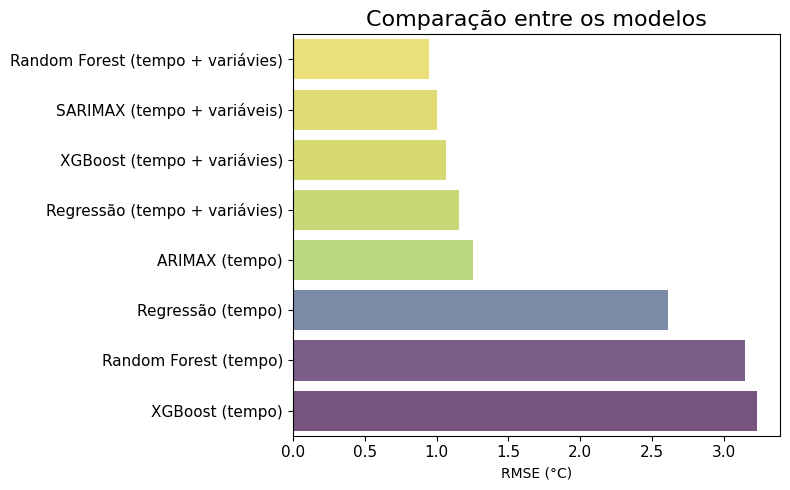

In [47]:
plt.figure(figsize=(8,5))
sns.barplot(data=resultados_df, x='RMSE', y='Modelo', hue='RMSE', palette='viridis_r', alpha=0.7, legend=False)
plt.title('Comparação entre os modelos', fontsize=16)
plt.xlabel('RMSE (°C)')
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.ylabel('')
plt.tight_layout()
plt.savefig('output/Comparacao_modelos.png', dpi=400)
plt.show()


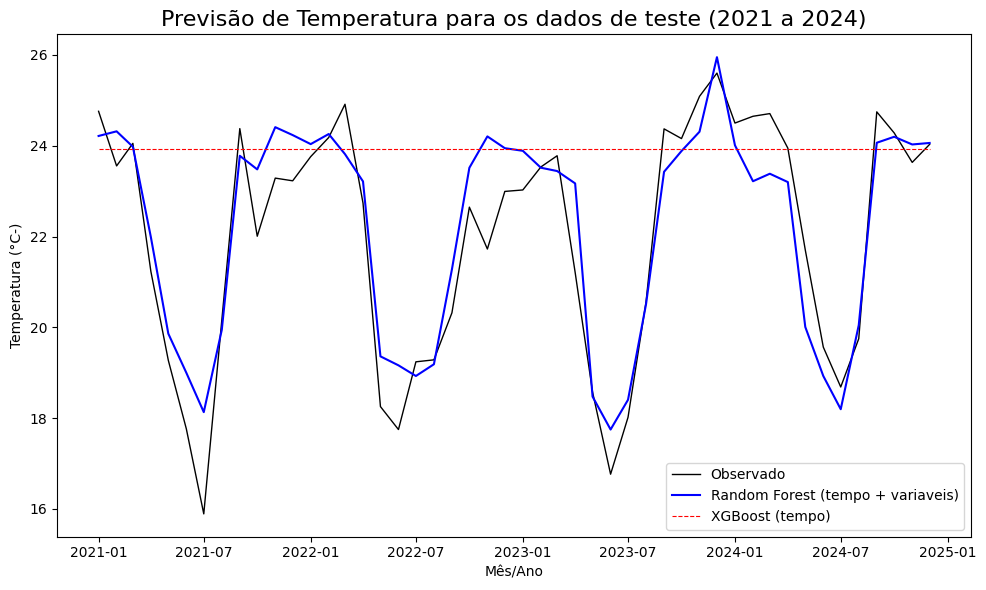

In [48]:
plt.figure(figsize=(10,6))
plt.plot(df_test['mes'], y_test, label='Observado', color='black', linewidth=1)
plt.plot(df_test['mes'], rf_full.predict(X_test_full), label='Random Forest (tempo + variaveis)', color='blue', linewidth=1.5)
plt.plot(df_test['mes'], xgb_base.predict(X_test_base), label='XGBoost (tempo)', color='red', linestyle='--', linewidth=0.8)
plt.legend()
plt.title("Previsão de Temperatura para os dados de teste (2021 a 2024)", fontsize=16)
plt.xlabel('Mês/Ano')
plt.ylabel('Temperatura (°C­)')
plt.tight_layout()
plt.savefig('output/Previsao_temperatura_dados_teste.png', dpi=400)
plt.show()

In [49]:
df_erro = pd.DataFrame({
    'Observado': y_test,
    'Random_Forest_var': rf_full.predict(X_test_full),
    'ARIMAX_tempo': y_pred_arimax_tempo,
    'XGBoost_tempo': xgb_base.predict(X_test_base),
    'Erro_RF': y_test - rf_full.predict(X_test_full),
    'Erro_ARIMAX': y_test - y_pred_arimax_tempo,
    'Erro_XGB': y_test - xgb_base.predict(X_test_base)
})
df_erro.head(10)

,Observado,Random_Forest_var,ARIMAX_tempo,XGBoost_tempo,Erro_RF,Erro_ARIMAX,Erro_XGB
492,24.758731,24.215342,24.579594,23.934877,0.543389,0.179136,0.823853
493,23.555334,24.317438,24.796202,23.934877,-0.762104,-1.240868,-0.379543
494,24.052049,23.977530,24.121830,23.934877,0.074519,-0.069780,0.117172
495,21.228937,21.984760,22.766272,23.934877,-0.755823,-1.537335,-2.705941
496,19.271204,19.859647,19.906813,23.934877,-0.588443,-0.635609,-4.663673
497,17.761759,18.997516,19.045504,23.934877,-1.235758,-1.283745,-6.173119
498,15.888886,18.130740,18.809619,23.934877,-2.241853,-2.920733,-8.045991
499,20.152652,19.943558,20.151884,23.934877,0.209095,0.000768,-3.782225
500,24.377579,23.778392,22.812588,23.934877,0.599187,1.564991,0.442701
501,22.006361,23.478926,23.979185,23.934877,-1.472565,-1.972824,-1.928516


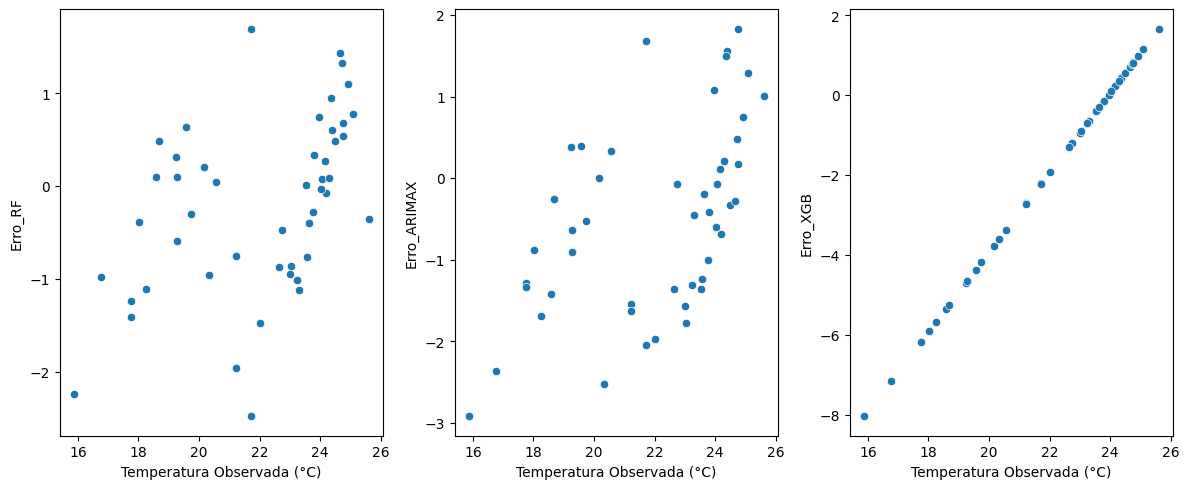

In [50]:
variaveis = ['Erro_RF', 'Erro_ARIMAX', 'Erro_XGB']

fig, axes = plt.subplots(ncols=len(variaveis), figsize=(12,5))

for ax, var in zip(axes, variaveis):
  sns.scatterplot(data=df_erro, x='Observado', y=var, ax=ax)
  ax.set_ylabel(f'{var}')
  ax.set_xlabel('Temperatura Observada (°C)')
plt.tight_layout()
plt.savefig('output/Erro_modelos_dados_teste.png', dpi=400)
plt.show()

#### Simulação Monte Carlo para variáveis exógenas futuras (2025 - 2050)

In [51]:
meses_futuros = pd.date_range(start='2025-01-01', end='2050-12-01', freq='MS')
np.random.seed(42)

In [52]:
stats = df_train.copy()
stats['mes_num'] = stats['mes'].dt.month

In [53]:
media_mensal = stats.groupby('mes_num')[['cloud','pressao_log', 'ssdr_log', 'umidade_relativa']].mean()
desvio_mensal = stats.groupby('mes_num')[['cloud','pressao_log', 'ssdr_log', 'umidade_relativa']].std()

In [54]:
# Simulação para cada mês futuro
dados_futuros = []
for i, data in enumerate(meses_futuros):
  mes = data.month
  entrada = {
      'mes': data,
      'tempo': len(df_mensal_modelo)+i,
  }
  for var in ['cloud','pressao_log', 'ssdr_log', 'umidade_relativa']:
    mu = media_mensal.loc[mes, var]
    sigma = desvio_mensal.loc[mes, var]
    entrada[var] = np.random.normal(mu, sigma)
  dados_futuros.append(entrada)

df_futuro = pd.DataFrame(dados_futuros)
exog_futuro = df_futuro[X_col_full]

In [55]:
exog_futuro

,tempo,pressao_log,ssdr_log,cloud,umidade_relativa
0,540,6.919745,6.517068,0.788917,0.834919
1,541,6.920540,6.538454,0.667686,0.792817
2,542,6.921675,6.336601,0.546179,0.739292
3,543,6.921183,6.134049,0.501996,0.707452
4,544,6.925000,6.040612,0.355790,0.659416
...,...,...,...,...,...
307,847,6.928792,6.242418,0.439295,0.531766
308,848,6.926310,6.290512,0.431094,0.755164
309,849,6.921146,6.528792,0.735186,0.772163
310,850,6.919964,6.449945,0.601299,0.666809


In [56]:
exog_future_tempo = exog_futuro[['tempo']]
exog_tempo = X_test_full[['tempo']]
exog_forecast_tempo = pd.concat([exog_tempo, exog_future_tempo], ignore_index=True)
exog_forecast_tempo.shape

(360, 1)

In [57]:
y_pred_futuro_rf = rf_full.predict(exog_futuro)
y_pred_futuro_arimax = arimax_tempo_fit.predict(start=len(df_mensal_modelo), end=len(df_mensal_modelo)+len(meses_futuros)-1, exog=exog_forecast_tempo)

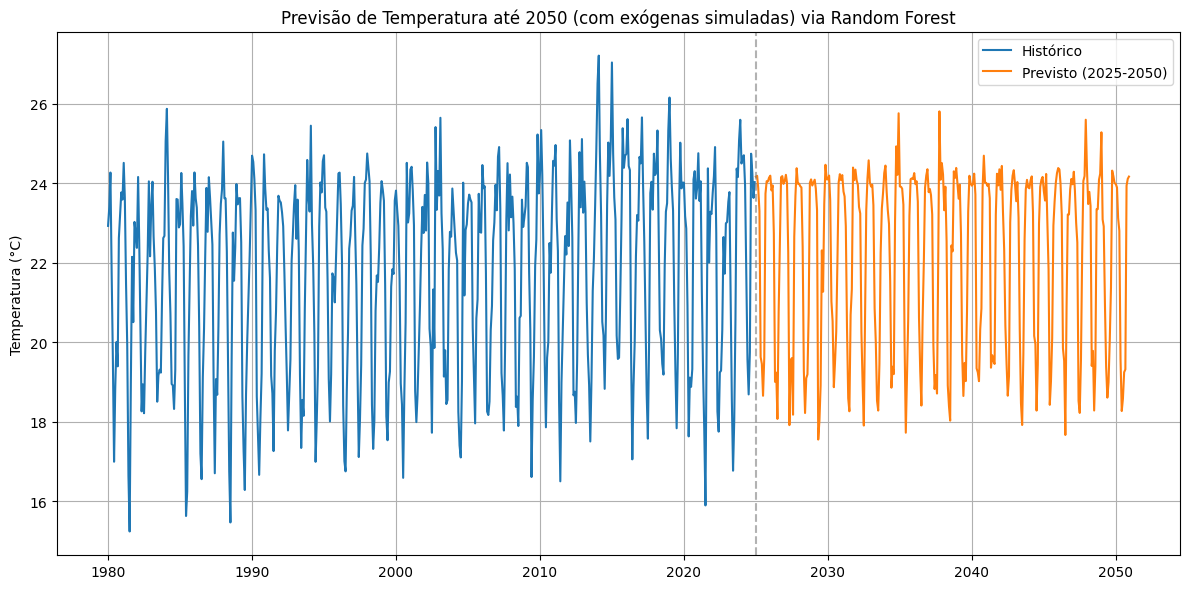

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(df_mensal_modelo['mes'], df_mensal_modelo[y_col], label='Histórico')
plt.plot(df_futuro['mes'], y_pred_futuro_rf, label='Previsto (2025-2050)')
plt.axvline(pd.to_datetime('2025-01-01'), color='gray', linestyle='--', alpha=0.6)
plt.title("Previsão de Temperatura até 2050 (com exógenas simuladas) via Random Forest")
plt.xlabel("")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/Previsao_temperatura_ate_2050_com_RF.png', dpi=400)
plt.show()

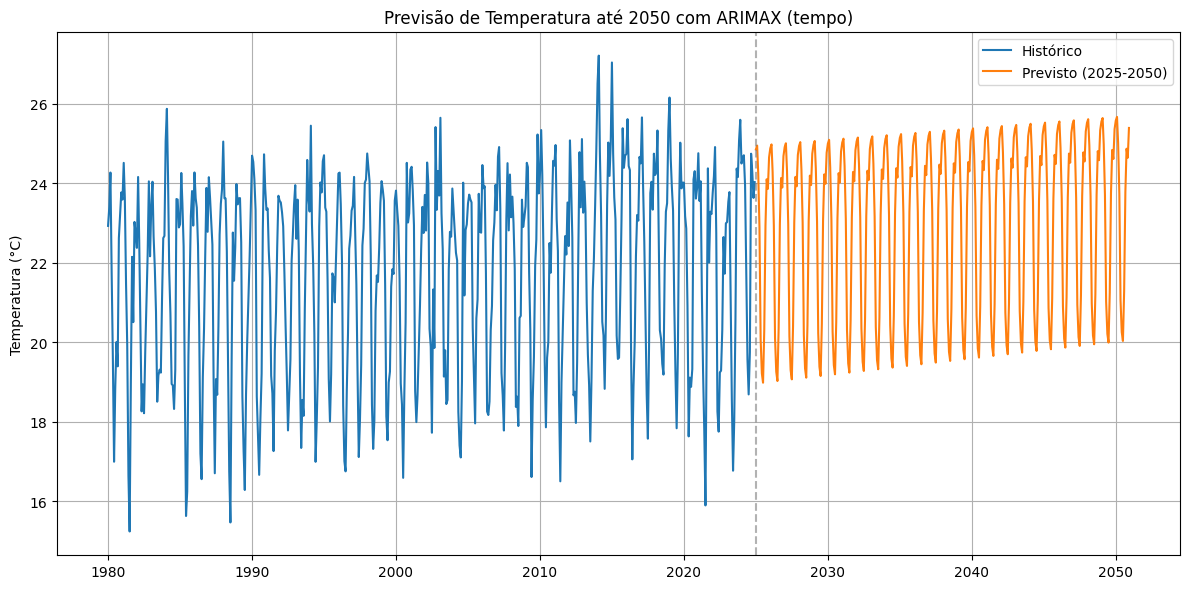

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(df_mensal_modelo['mes'], df_mensal_modelo[y_col], label='Histórico')
plt.plot(df_futuro['mes'], y_pred_futuro_arimax, label='Previsto (2025-2050)')
plt.axvline(pd.to_datetime('2025-01-01'), color='gray', linestyle='--', alpha=0.6)
plt.title("Previsão de Temperatura até 2050 com ARIMAX (tempo)")
plt.xlabel("")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/Previsao_temperatura_ate_2050_arimax.png', dpi=400)
plt.show()

#### Média Anual até 2050

In [60]:
df_media_anual = df_futuro.copy()
df_media_anual['y_pred_rf_var'] = y_pred_futuro_rf
df_media_anual

,mes,tempo,cloud,pressao_log,ssdr_log,umidade_relativa,y_pred_rf_var
0,2025-01-01,540,0.788917,6.919745,6.517068,0.834919,24.168094
1,2025-02-01,541,0.667686,6.920540,6.538454,0.792817,24.189034
2,2025-03-01,542,0.546179,6.921675,6.336601,0.739292,23.881512
3,2025-04-01,543,0.501996,6.921183,6.134049,0.707452,23.300413
4,2025-05-01,544,0.355790,6.925000,6.040612,0.659416,19.626541
...,...,...,...,...,...,...,...
307,2050-08-01,847,0.439295,6.928792,6.242418,0.531766,19.243475
308,2050-09-01,848,0.431094,6.926310,6.290512,0.755164,19.314361
309,2050-10-01,849,0.735186,6.921146,6.528792,0.772163,23.942189
310,2050-11-01,850,0.601299,6.919964,6.449945,0.666809,24.114470


In [ ]:
df_media_anual_final = df_media_anual.groupby(df_media_anual['mes'].dt.year)['y_pred_rf_var'].mean().reset_index()
df_media_anual_final['temp_historica'] = df_mensal_modelo['temp_media'].mean()
df_media_anual_final['diferenca'] = df_media_anual_final['y_pred_rf_var']-df_media_anual_final['temp_historica']
df_media_anual_final

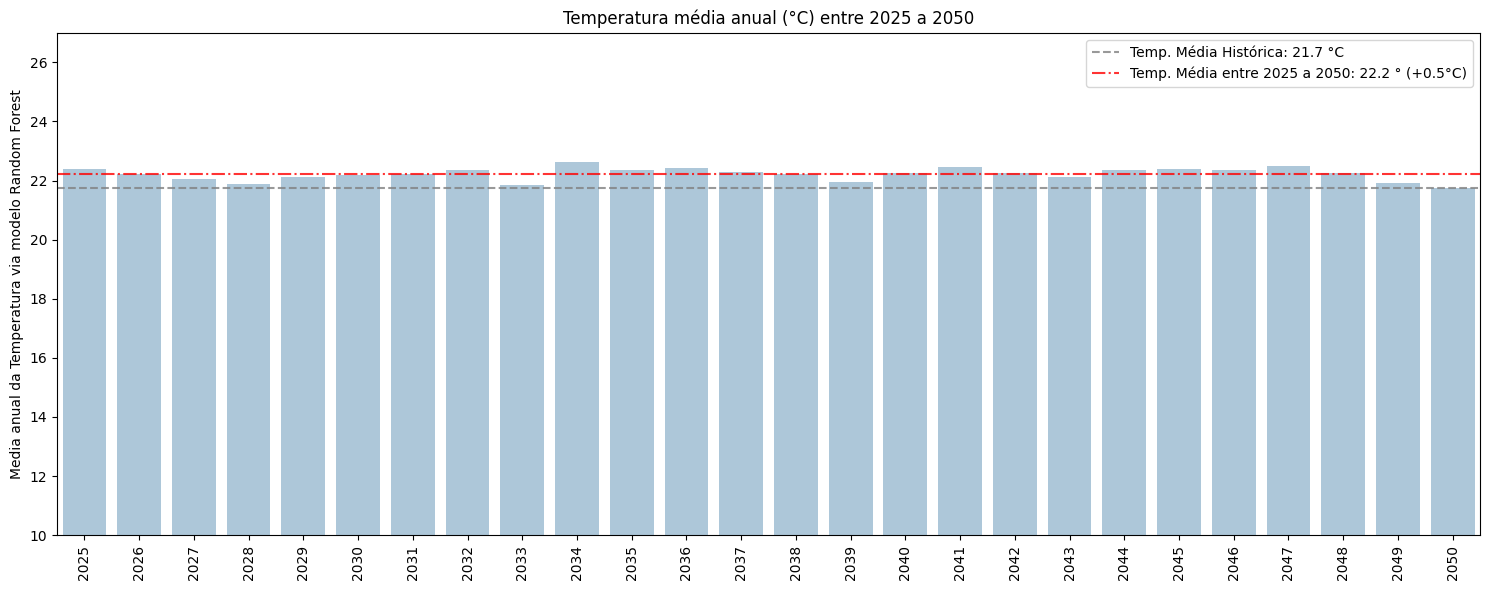

In [73]:
plt.figure(figsize=(15,6))
sns.barplot(data =df_media_anual_final, x='mes', y='y_pred_rf_var', alpha=0.4)
plt.axhline(df_mensal_modelo['temp_media'].mean(), color='gray',linestyle='--', alpha=0.8, label='Temp. Média Histórica: 21.7 °C')
plt.axhline(df_media_anual_final['y_pred_rf_var'].mean(), color='red', linestyle='-.', alpha=0.8, label='Temp. Média entre 2025 a 2050: 22.2 ° (+0.5°C)')
plt.xticks(rotation=90)
plt.ylim(10,27)
plt.xlabel('')
plt.title('Temperatura média anual (°C) entre 2025 a 2050')
plt.ylabel('Media anual da Temperatura via modelo Random Forest')
plt.legend()
plt.tight_layout()
plt.savefig('output/Temperatura_media_anual_2025_a_2050.png', dpi=400)
plt.show()